In [1]:
WIDTH = 320
HEIGHT = 240
EPOCHS = 10
BATCH_SIZE = 4
TRAIN_CSV = "./datasets/data/nyu2_train.csv"

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

%run utils/datasets.ipynb
%run utils/utils.ipynb

In [3]:
partition, labels = load_train_csv(TRAIN_CSV)

In [4]:
partition['train'] = partition['train'][:20000]
partition['validation'] = partition['validation'][:5000]

In [5]:
print(len(partition['train']), len(partition['validation']))

20000 5000


In [6]:
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=BATCH_SIZE,
                                   dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=BATCH_SIZE,
                                     dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

In [7]:
def downsampling_block(input_tensor, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
    x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = concatenate([x, concat_with], axis=3)

    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    return x

In [8]:
def build(height, width, depth):
    # input
    i = Input(shape=(height, width, depth))

    # encoder
    conv1 = downsampling_block(i, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = downsampling_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = downsampling_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = downsampling_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # bottleneck
    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # decoder
    conv6 = upsampling_block(conv5, 256, "up1", concat_with=conv4)
    conv7 = upsampling_block(conv6, 128, "up2", concat_with=conv3)
    conv8 = upsampling_block(conv7, 64, "up3", concat_with=conv2)
    conv9 = upsampling_block(conv8, 32, "up4", concat_with=conv1)
    
    # output
    o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

    model = Model(inputs=i, outputs=o)
    return model

In [9]:
model = build(HEIGHT, WIDTH, 3)

In [10]:
# model.summary()

In [11]:
model.compile(optimizer=opt,
              loss=lambda y_true, y_pred : gen_depth_loss(y_true, y_pred, (1.0,1.0,0.1)),
              metrics=[depth_acc])

In [12]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LEARNING_RATE
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

In [13]:
r = model.fit(training_generator, validation_data=validation_generator,
              epochs=EPOCHS, callbacks=[LearningRateScheduler(poly_decay)])

Epoch 1/10
5000/5000 [==============================] - 1212s 241ms/step - loss: 0.1745 - depth_acc: 0.7245 - val_loss: 0.1594 - val_depth_acc: 0.7437 - lr: 1.0000e-04
Epoch 2/10
5000/5000 [==============================] - 1195s 239ms/step - loss: 0.1542 - depth_acc: 0.7681 - val_loss: 0.1641 - val_depth_acc: 0.7676 - lr: 9.0000e-05
Epoch 3/10
5000/5000 [==============================] - 1204s 241ms/step - loss: 0.1435 - depth_acc: 0.7911 - val_loss: 0.1370 - val_depth_acc: 0.7950 - lr: 8.0000e-05
Epoch 4/10
5000/5000 [==============================] - 1202s 240ms/step - loss: 0.1343 - depth_acc: 0.8092 - val_loss: 0.1295 - val_depth_acc: 0.8264 - lr: 7.0000e-05
Epoch 5/10
5000/5000 [==============================] - 1204s 241ms/step - loss: 0.1263 - depth_acc: 0.8247 - val_loss: 0.1248 - val_depth_acc: 0.8134 - lr: 6.0000e-05
Epoch 6/10
5000/5000 [==============================] - 1208s 242ms/step - loss: 0.1189 - depth_acc: 0.8366 - val_loss: 0.1139 - val_depth_acc: 0.8502 - lr: 5.0

In [14]:
print(r.history)

{'loss': [0.1744740903377533, 0.1542266309261322, 0.14345626533031464, 0.1343187540769577, 0.1262846142053604, 0.11892294883728027, 0.11237866431474686, 0.10693126171827316, 0.10227286070585251, 0.09840573370456696], 'depth_acc': [0.724479615688324, 0.7680643796920776, 0.7911401391029358, 0.8092215061187744, 0.8246686458587646, 0.8366309404373169, 0.8493178486824036, 0.8593849539756775, 0.8682068586349487, 0.8749191164970398], 'val_loss': [0.15938441455364227, 0.16405999660491943, 0.13700909912586212, 0.12952665984630585, 0.12484180927276611, 0.11392129957675934, 0.10945440828800201, 0.10493035614490509, 0.10107073932886124, 0.09800591319799423], 'val_depth_acc': [0.7437363266944885, 0.7675524950027466, 0.7949947714805603, 0.8264250159263611, 0.8133983016014099, 0.8502021431922913, 0.8597205281257629, 0.8691275119781494, 0.8774094581604004, 0.8844792246818542], 'lr': [1e-04, 9e-05, 8e-05, 7e-05, 6e-05, 5e-05, 4e-05, 3e-05, 2e-05, 1e-05]}


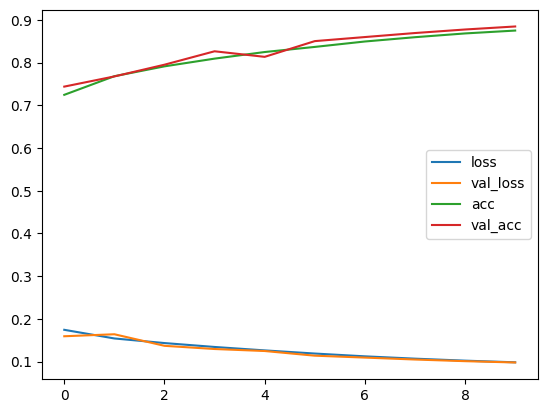

In [15]:
plot_history(r.history)

In [16]:
print(save_model('unet', model))

model_unet_1708465933.keras
